# Interpret computer vision model with Captum

This notebook will walk you through the process of gaining information about your CNN with Captum. This notebook is based on [one of Captums official tutorials](https://captum.ai/tutorials/Resnet_TorchVision_Interpret).

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Model-Interpretation/blob/master/Captum/Interpret_computer_vision_model_with_Captum.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Model-Interpretation/blob/master/Captum/Interpret_computer_vision_model_with_Captum.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install Captum

Installing Captum is super simple. All you need is a simple pip install.

In [1]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Getting started

Before we can use Captum to get information about a model we need to import everything necessary and load the model as well as a couple of test images. To do so we will make use of [torchvisions pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) and some images from the ImageNet data-set.

In [2]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

torch.manual_seed(0)
np.random.seed(0)

Load pre-trained Resnet model and set it to eval mode:

In [3]:
model = models.resnet18(pretrained=True)
model = model.eval()

Get the index to class mapping file for the ImageNet data-set and read it into memory.

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2022-07-02 12:50:27--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.17.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.17.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2022-07-02 12:50:27 (2.18 MB/s) - ‘/root/.torch/models/imagenet_class_index.json.1’ saved [35363/35363]



In [5]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Next we create methods to transform input images so they can be used with the model.

In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

Now we can download some images and start making predictions

In [7]:
!mkdir $HOME/images/
!wget -O $HOME/images/dog1.jpg https://www.rover.com/blog/wp-content/uploads/2011/11/german-shepherd-960x540.jpg

mkdir: cannot create directory ‘/root/images/’: File exists
--2022-07-02 12:50:28--  https://www.rover.com/blog/wp-content/uploads/2011/11/german-shepherd-960x540.jpg
Resolving www.rover.com (www.rover.com)... 104.18.165.26, 104.18.164.26, 104.18.166.26, ...
Connecting to www.rover.com (www.rover.com)|104.18.165.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/root/images/dog1.jpg’

/root/images/dog1.j     [ <=>                ] 108.55K  --.-KB/s    in 0.02s   

2022-07-02 12:50:28 (5.04 MB/s) - ‘/root/images/dog1.jpg’ saved [111154]



In [8]:
img = Image.open(os.getenv("HOME")+'/images/dog1.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [9]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: German_shepherd ( 0.9925925135612488 )


## Analysing predictions

The prediction seems correct but we can't be sure yet that the model really learned what a dog looks like. To be sure we will use [General Attribution methods](https://captum.ai/docs/algorithms) that will help us to get an understanding of what the model is looking for when making a certain prediction.

We will start of with Integrated Gradients which represents the integral of gradients with respect to a input along the path of a baseline to the input.

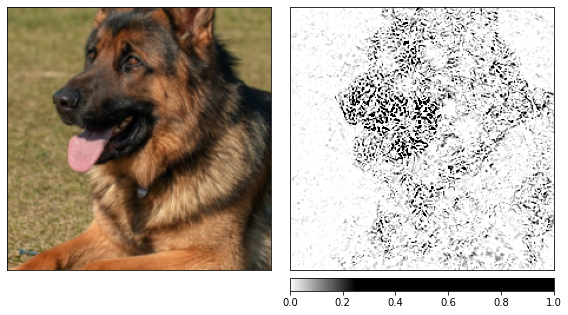

In [10]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

# create custom colormap for visualizing the result
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


# visualize the results using the visualize_image_attr helper method
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)

The above result gives us a rough idea but we can get an even better image by smoothing the output using a noise tunnel.

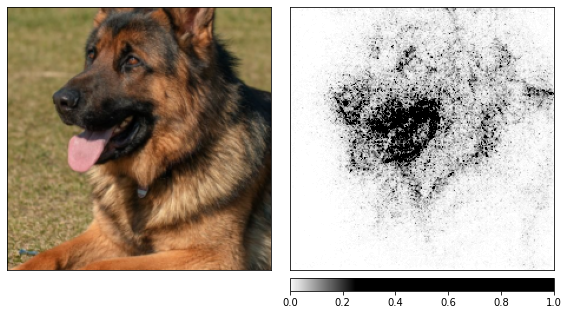

In [11]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)

In the above images we can see that the model heavily focuses at the head of the dog which is reasonable (at least for me).

Another great method for gaining insight about the global behaviour is GradientShap, which is a gradient method to compute [SHAP values](https://christophm.github.io/interpretable-ml-book/shap.html).

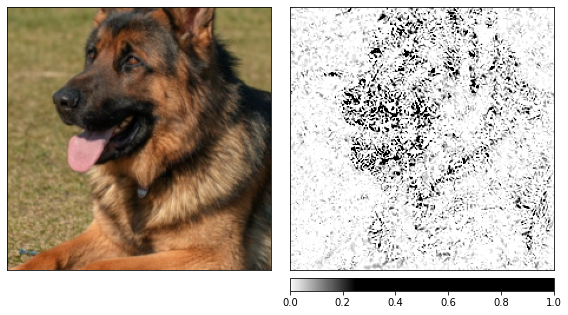

In [12]:
gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 255])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)

That's all from this notebook. I hope you learned something. If you want to learn more about Captum check out the other notebooks as well as [my Captum blog post](https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum/).